In [1]:
import numpy as np
import pandas as pd

# pd.set_option('display.height', 1000)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("max_colwidth", None)
from IPython.core.display import HTML, display

display(HTML("<style>.container { width:100% !important; }</style>"))


def df_stats(df):
    from tabulate import tabulate

    while True:
        print("\n***** Shape: ", df.shape, " *****\n")

        columns_list = df.columns.values.tolist()
        isnull_list = df.isnull().sum().values.tolist()
        isunique_list = df.nunique().values.tolist()
        dtypes_list = df.dtypes.tolist()

        list_stat_val = list(zip(columns_list, isnull_list, isunique_list, dtypes_list))
        df_stat_val = pd.DataFrame(list_stat_val, columns=["Name", "Null", "Unique", "Dtypes"])
        print(tabulate(df_stat_val, headers="keys", tablefmt="psql"))
    return df.head()

/tmp/ipykernel_1633304/441343652.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


In [2]:
# Load the specified CSV file
csv_file_path = "/media/data1/ravram/DeepCORO/processed_dataframes/ObjectRecon_SWIN3D_2016-2024_inference_predictions_with_df_metadata_and_report.csv"
df_predictions = pd.read_csv(csv_file_path)


/tmp/ipykernel_1633304/616661361.py:3: DtypeWarning: Columns (4,5,10,17,22,26,32,33,35,36,37,40,41,43,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,241,242,244,245,246,249,250,251,254,255,256,257,258,266,267,269,270,272,274,275,278,279,280,284,288,289,290,294,298,299,300,301,303,306,309,312,315,316,317,318,319,320,323,324,325,327,328,329,333,345,346,347,350,351,352,354,355,356,357,358,359,360,362,365,367,373,376,377,378,379,381,384,385,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,408,409,410,411,412,413,414,415,416,417,418,419) have mixed types. Specify dtype option on import or set low_memory=False.
  df_predictions = pd.read_csv(csv_file_path)


In [4]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

##############################################################################
# 1) Base Vessel Definitions & Order                                         #
##############################################################################
labels_to_vessel_names = {
    "leftmain_stenosis": "the Left Main Coronary Artery (LMCA)",
    "lad_stenosis": "the proximal LAD",
    "mid_lad_stenosis": "the mid LAD", 
    "dist_lad_stenosis": "the distal LAD",
    "D1_stenosis": "D1 branch",
    "D2_stenosis": "D2 branch",
    "lcx_stenosis": "the proximal LCX",
    "dist_lcx_stenosis": "the distal LCX",
    "om1_stenosis": "OM1",
    "om2_stenosis": "OM2",
    "prox_rca_stenosis": "the proximal RCA",
    "mid_rca_stenosis": "the mid RCA",
    "dist_rca_stenosis": "the distal RCA",
    "pda_stenosis": "the PDA",
    "posterolateral_stenosis": "the posterolateral branch",
    "bx_stenosis": "Ramus",
    "lima_or_svg_stenosis": "the LIMA or SVG graft",
}

# Define RCA specific vessels
rca_vessels = [
    "prox_rca_stenosis",
    "mid_rca_stenosis", 
    "dist_rca_stenosis",
    "pda_stenosis",
    "posterolateral_stenosis"
]

# Define non-RCA vessels 
non_rca_vessels = [
    "leftmain_stenosis",
    "lad_stenosis",
    "mid_lad_stenosis", 
    "dist_lad_stenosis",
    "D1_stenosis",
    "D2_stenosis",
    "lcx_stenosis",
    "dist_lcx_stenosis",
    "om1_stenosis",
    "om2_stenosis",
    "bx_stenosis",
    "lima_or_svg_stenosis"
]

##############################################################################
# 2) Short Formatting Helpers                                                #
##############################################################################

def format_stenosis_value(percent: float) -> str:
    if percent == 0:
        return "no significant stenosis"
    elif 0 < percent < 50:
        return f"mild stenosis (~{percent}%)"
    elif 50 <= percent < 70:
        return f"moderate stenosis (~{percent}%)"
    elif 70 <= percent < 90:
        return f"severe stenosis (~{percent}%)"
    else:
        return f"critical stenosis (~{percent}%)"

def format_calcification_value(calcif: str) -> str:
    txt = calcif.lower()
    if "no calcification" in txt or "pas de calcification" in txt:
        return "no calcifications"
    elif "minimes" in txt or "mild" in txt:
        return "minimal calcifications"
    elif "modérées" in txt or "moderate" in txt:
        return "moderate calcifications"
    elif "importantes" in txt or "severe" in txt:
        return "severe calcifications"
    return f"calcifications: '{calcif}'"

def format_ifr_value(ifr: float) -> str:
    ifr_str = f"{ifr:.2f}"
    if ifr > 0.89:
        return f"IFR normal (~{ifr_str})"
    return f"IFR abnormal (~{ifr_str})"

##############################################################################
# 3) Main Report Function with Custom Rules                                  #
##############################################################################

def create_report(row: pd.Series, coronary_specific_report: bool = True) -> str:
    """
    Builds a single short report per row using:
    - Coronary dominance rules
    - Graft presence rules
    - Combined line per vessel (stenosis, calcif, IFR)
    - Optional coronary specificity based on object_value
    """
    # 1) Determine dominance and graft presence
    dom_raw = str(row.get("coronary_dominance_consensus", ""))
    dom_lower = dom_raw.lower()
    conclusion_text = str(row.get("Conclusion", "")).lower()
    has_graft = ("pontage" in conclusion_text) or (row.get("bypass_graft", 0) == 1)

    # 2) Build vessel list based on object_value if coronary_specific_report is True
    if coronary_specific_report:
        if row.get("object_value") == 9:  # RCA
            local_order = rca_vessels[:]
        elif row.get("object_value") == 5:  # Non-RCA
            local_order = non_rca_vessels[:]
        else:
            return "Invalid object_value for coronary specific report"
    else:
        local_order = vessel_order[:]

    # If not Left Dominant, keep default naming;
    # if left dominant, rename 'pda_stenosis' and 'posterolateral_stenosis'
    vessel_dict = labels_to_vessel_names.copy()
    if "left" in dom_lower:
        vessel_dict["pda_stenosis"] = "the LEFT PDA"
        vessel_dict["posterolateral_stenosis"] = "the LEFT posterolateral branch"

    # If no graft presence, remove lima_or_svg_stenosis
    if not has_graft:
        if "lima_or_svg_stenosis" in local_order:
            local_order.remove("lima_or_svg_stenosis")

    # 3) Build each vessel's text
    lines = []
    for stenosis_label in local_order:
        prefix = stenosis_label.replace("_stenosis", "")
        vname = vessel_dict.get(stenosis_label, stenosis_label)

        # Gather info from columns
        desc = []
        # Stenosis
        st_val = row.get(stenosis_label, -1)
        if pd.notna(st_val) and st_val != -1:
            desc.append(format_stenosis_value(float(st_val)))
        # Calcif
        calc_label = prefix + "_calcif"
        calc_val = row.get(calc_label, "-1")
        if isinstance(calc_val, str) and calc_val.strip() != "-1":
            desc.append(format_calcification_value(calc_val))
        # IFR
        ifr_label = prefix + "_IFRHYPEREMIE"
        ifr_val = row.get(ifr_label, -1)
        if pd.notna(ifr_val) and ifr_val != -1:
            desc.append(format_ifr_value(float(ifr_val)))

        # If we got any descriptors, combine in one short sentence
        if desc:
            # If multiple descriptors, separate by commas, last with 'and'
            if len(desc) == 1:
                combined = desc[0]
            else:
                combined = ", ".join(desc[:-1]) + ", and " + desc[-1]
            lines.append(f"{vname} has {combined}.")

    # 4) Add coronary dominance if not empty
    if dom_raw:
        lines.append(f"The coronary circulation is {dom_raw}.")

    # Return final or default
    final_report = "\n".join(lines)
    if not final_report.strip():
        return "No significant findings or additional data available."
    return final_report

##############################################################################
# 4) Example Usage                                                           #
##############################################################################
df_predictions["Report"] = df_predictions.progress_apply(lambda x: create_report(x, coronary_specific_report=True), axis=1)

  0%|          | 0/1051259 [00:00<?, ?it/s]

100%|██████████| 1051259/1051259 [01:03<00:00, 16558.15it/s]


In [5]:
# Create bypass_graft column based on whether Conclusion contains "pontage" (case-insensitive)
df_predictions['bypass_graft'] = df_predictions['Conclusion'].str.contains('pontage', case=False, na=False).astype(int)
display(df_predictions.bypass_graft.value_counts())

bypass_graft
0    945772
1    105487
Name: count, dtype: int64

In [6]:
import os

output_file_path = "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108_RCA_LCA.csv"
output_dir = os.path.dirname(output_file_path)

# Check if the directory exists, if not create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Drop rows where 'External_Exam' is True
df_predictions = df_predictions[df_predictions["External_Exam"] != True]
df_predictions = df_predictions[df_predictions["bypass_graft"] != 1]

df_non_nan_reports = df_predictions.dropna(subset=["Report"])
# Filter the dataframe to keep only rows where 'object_value' is 5 or 9
df_non_nan_reports = df_non_nan_reports[df_non_nan_reports["object_value"].isin([5, 9])]
# List of stenosis columns to check
stenosis_columns = [
    'D2_stenosis', 'D3_stenosis', 'RVG1_stenosis', 'RVG2_stenosis', 
    'S1_stenosis', 'bx_stenosis', 'diagonal_stenosis', 'dist_lad_stenosis',
    'dist_lcx_stenosis', 'dist_rca_stenosis', 'lad_stenosis', 'lcx_stenosis',
    'leftmain_stenosis'
]

# Create a boolean DataFrame indicating if each cell is NaN or -1.0
is_na_or_minus_one = df_non_nan_reports[stenosis_columns].isna() | (df_non_nan_reports[stenosis_columns] == -1.0)

# Create a mask for rows where NOT ALL stenosis columns are NaN or -1.0
mask = ~is_na_or_minus_one.all(axis=1)

# Filter the DataFrame to drop rows meeting the unwanted condition
df_non_nan_reports = df_non_nan_reports[mask]
df_non_nan_reports.to_csv(output_file_path, sep="α", index=False, header=True)

In [7]:
# Get top 13 reports and print their lengths
top_13_reports = df_non_nan_reports.Report.value_counts().head(13)
for report in top_13_reports.index:
    print(f"Length: {len(report)} characters")

Length: 470 characters
Length: 266 characters
Length: 265 characters
Length: 469 characters
Length: 265 characters
Length: 469 characters
Length: 264 characters
Length: 298 characters
Length: 265 characters
Length: 468 characters
Length: 469 characters
Length: 468 characters
Length: 469 characters


In [8]:
# First, sort the dataframe by 'SeriesTime' and group by 'StudyInstanceUID'
df_sorted = df_non_nan_reports.assign(SeriesTime=pd.to_numeric(df_non_nan_reports.SeriesTime, errors='coerce')).sort_values(by='SeriesTime')

# Group by 'StudyInstanceUID' and keep the top 15 earliest 'SeriesTime'
df_top15 = df_sorted.groupby('StudyInstanceUID').head(15)

# Define a function to pick rows with object_value == 5 and 9
def pick_values(group):
    # Get total number of rows in group
    total_rows = len(group)
    
    # Calculate target numbers (60% for value 5, 40% for value 9)
    target_5 = min(7, total_rows * 6 // 10)
    target_9 = min(5, total_rows * 4 // 10)
    
    # Filter rows for each object_value and sample required number
    group_5 = group[group['object_value'] == 5].head(target_5)
    group_9 = group[group['object_value'] == 9].head(target_9)
    
    # Concatenate the results
    return pd.concat([group_5, group_9])

# Apply the function to each group
df_final = df_top15.groupby('StudyInstanceUID').apply(pick_values).reset_index(drop=True)

/tmp/ipykernel_1568774/1912233115.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_top15.groupby('StudyInstanceUID').apply(pick_values).reset_index(drop=True)


In [9]:
display(df_final.object_value.value_counts())

object_value
5    158520
9     81741
Name: count, dtype: int64

In [10]:
# Split 70% of patients for train and 30% for validation
unique_patients = df_final["CathReport_MRN"].drop_duplicates()
train_size = int(0.9 * len(unique_patients))
train_patients = unique_patients.sample(n=train_size, random_state=42)
val_patients = unique_patients.drop(train_patients.index)

# Keep only the sampled patients in the dataframe
df_sampled = df_final[
    df_final["CathReport_MRN"].isin(train_patients)
    | df_final["CathReport_MRN"].isin(val_patients)
]

# Sample 300 unique StudyInstanceUID from the already split dataset
#unique_study_ids = df_sampled["StudyInstanceUID"].drop_duplicates().sample(n=300, random_state=42)

# Keep only the sampled StudyInstanceUIDs in the dataframe
#df_sampled = df_sampled[df_sampled["StudyInstanceUID"].isin(unique_study_ids)]

# Assign split based on CathReport_MRN
df_sampled.loc[df_sampled["CathReport_MRN"].isin(train_patients), "Split"] = "train"
df_sampled.loc[df_sampled["CathReport_MRN"].isin(val_patients), "Split"] = "val"

# Save the dataframe with the sampled StudyInstanceUIDs to a new CSV file
output_sampled_file_path = "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108_RCA_LCA.csv"
df_sampled.to_csv(output_sampled_file_path, sep="α", index=False)

display(df_sampled.Split.value_counts())

Split
train    216078
val       24183
Name: count, dtype: int64

In [11]:
import pandas as pd
output_sampled_file_path = "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108_RCA_LCA.csv"
df_sampled = pd.read_csv(output_sampled_file_path, sep="α")

display(df_sampled.object_value.value_counts())

/tmp/ipykernel_1568774/109834360.py:3: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_sampled = pd.read_csv(output_sampled_file_path, sep="α")


object_value
5    158520
9     81741
Name: count, dtype: int64

In [12]:
# Sample 30 unique StudyInstanceUIDs
sampled_study_ids = df_sampled["StudyInstanceUID"].unique()
sampled_study_ids = np.random.choice(sampled_study_ids, size=30, replace=False)

# Keep only rows matching the sampled StudyInstanceUIDs
df_sampled = df_sampled[df_sampled["StudyInstanceUID"].isin(sampled_study_ids)]
display(df_sampled.Split.value_counts())
display(df_sampled.StudyInstanceUID.value_counts())
df_sampled.to_csv('data/reports/report_sampled_200.csv', sep='α', index=False)


Split
train    165
val       33
Name: count, dtype: int64

StudyInstanceUID
2.16.124.113611.1.118.1.1.4928973    10
2.16.124.113611.1.118.1.1.5376194    10
2.16.124.113611.1.118.1.1.6790409    10
2.16.124.113611.1.118.1.1.6862377    10
2.16.124.113611.1.118.1.1.6106103    10
2.16.124.113611.1.118.1.1.4890211     9
2.16.124.113611.1.118.1.1.5763133     9
2.16.124.113611.1.118.1.1.4810145     9
2.16.124.113611.1.118.1.1.5198942     8
2.16.124.113611.1.118.1.1.4735025     8
2.16.124.113611.1.118.1.1.6341860     8
2.16.124.113611.1.118.1.1.5726623     8
2.16.124.113611.1.118.1.1.5068497     7
2.16.124.113611.1.118.1.1.6968248     7
2.16.124.113611.1.118.1.1.6955377     6
2.16.124.113611.1.118.1.1.6743710     6
2.16.124.113611.1.118.1.1.6255693     6
2.16.124.113611.1.118.1.1.6055469     6
2.16.124.113611.1.118.1.1.5169156     6
2.16.124.113611.1.118.1.1.6559811     6
2.16.124.113611.1.118.1.1.4718710     5
2.16.124.113611.1.118.1.1.5554945     5
2.16.124.113611.1.118.1.1.6981913     5
2.16.124.113611.1.118.1.1.6355567     5
2.16.124.113611.1.118.1

In [3]:
import pandas as pd
df_sampled = pd.read_csv('data/reports/report_sampled_200.csv', sep='α')

# Display rows where FileName matches the specified path
target_file = '/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024/1.3.12.2.1107.5.4.5.135214.30000024062510374540700010919.512.mp4'
matching_rows = df_sampled[df_sampled['FileName'] == target_file]
# Display Report column for matching StudyInstanceUID
study_id = matching_rows['StudyInstanceUID'].iloc[0]
study_reports = df_sampled[df_sampled['StudyInstanceUID'] == study_id]
display(study_reports[['FileName', 'StudyInstanceUID', 'Report']])


/tmp/ipykernel_1721447/2340057141.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df_sampled = pd.read_csv('data/reports/report_sampled_200.csv', sep='α')


,FileName,StudyInstanceUID,Report
170,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,the Left Main Coronary Artery (LMCA) has sever...
171,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,the Left Main Coronary Artery (LMCA) has sever...
172,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,the Left Main Coronary Artery (LMCA) has sever...
173,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,the Left Main Coronary Artery (LMCA) has sever...
174,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,the Left Main Coronary Artery (LMCA) has sever...
175,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,"the proximal RCA has severe stenosis (~70.0%),..."
176,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,"the proximal RCA has severe stenosis (~70.0%),..."
177,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,"the proximal RCA has severe stenosis (~70.0%),..."
178,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,"the proximal RCA has severe stenosis (~70.0%),..."
179,/media/data1/ravram/MHI_CATH_DICOM_VIDEOS/2024...,2.16.124.113611.1.118.1.1.6862377,"the proximal RCA has severe stenosis (~70.0%),..."


9


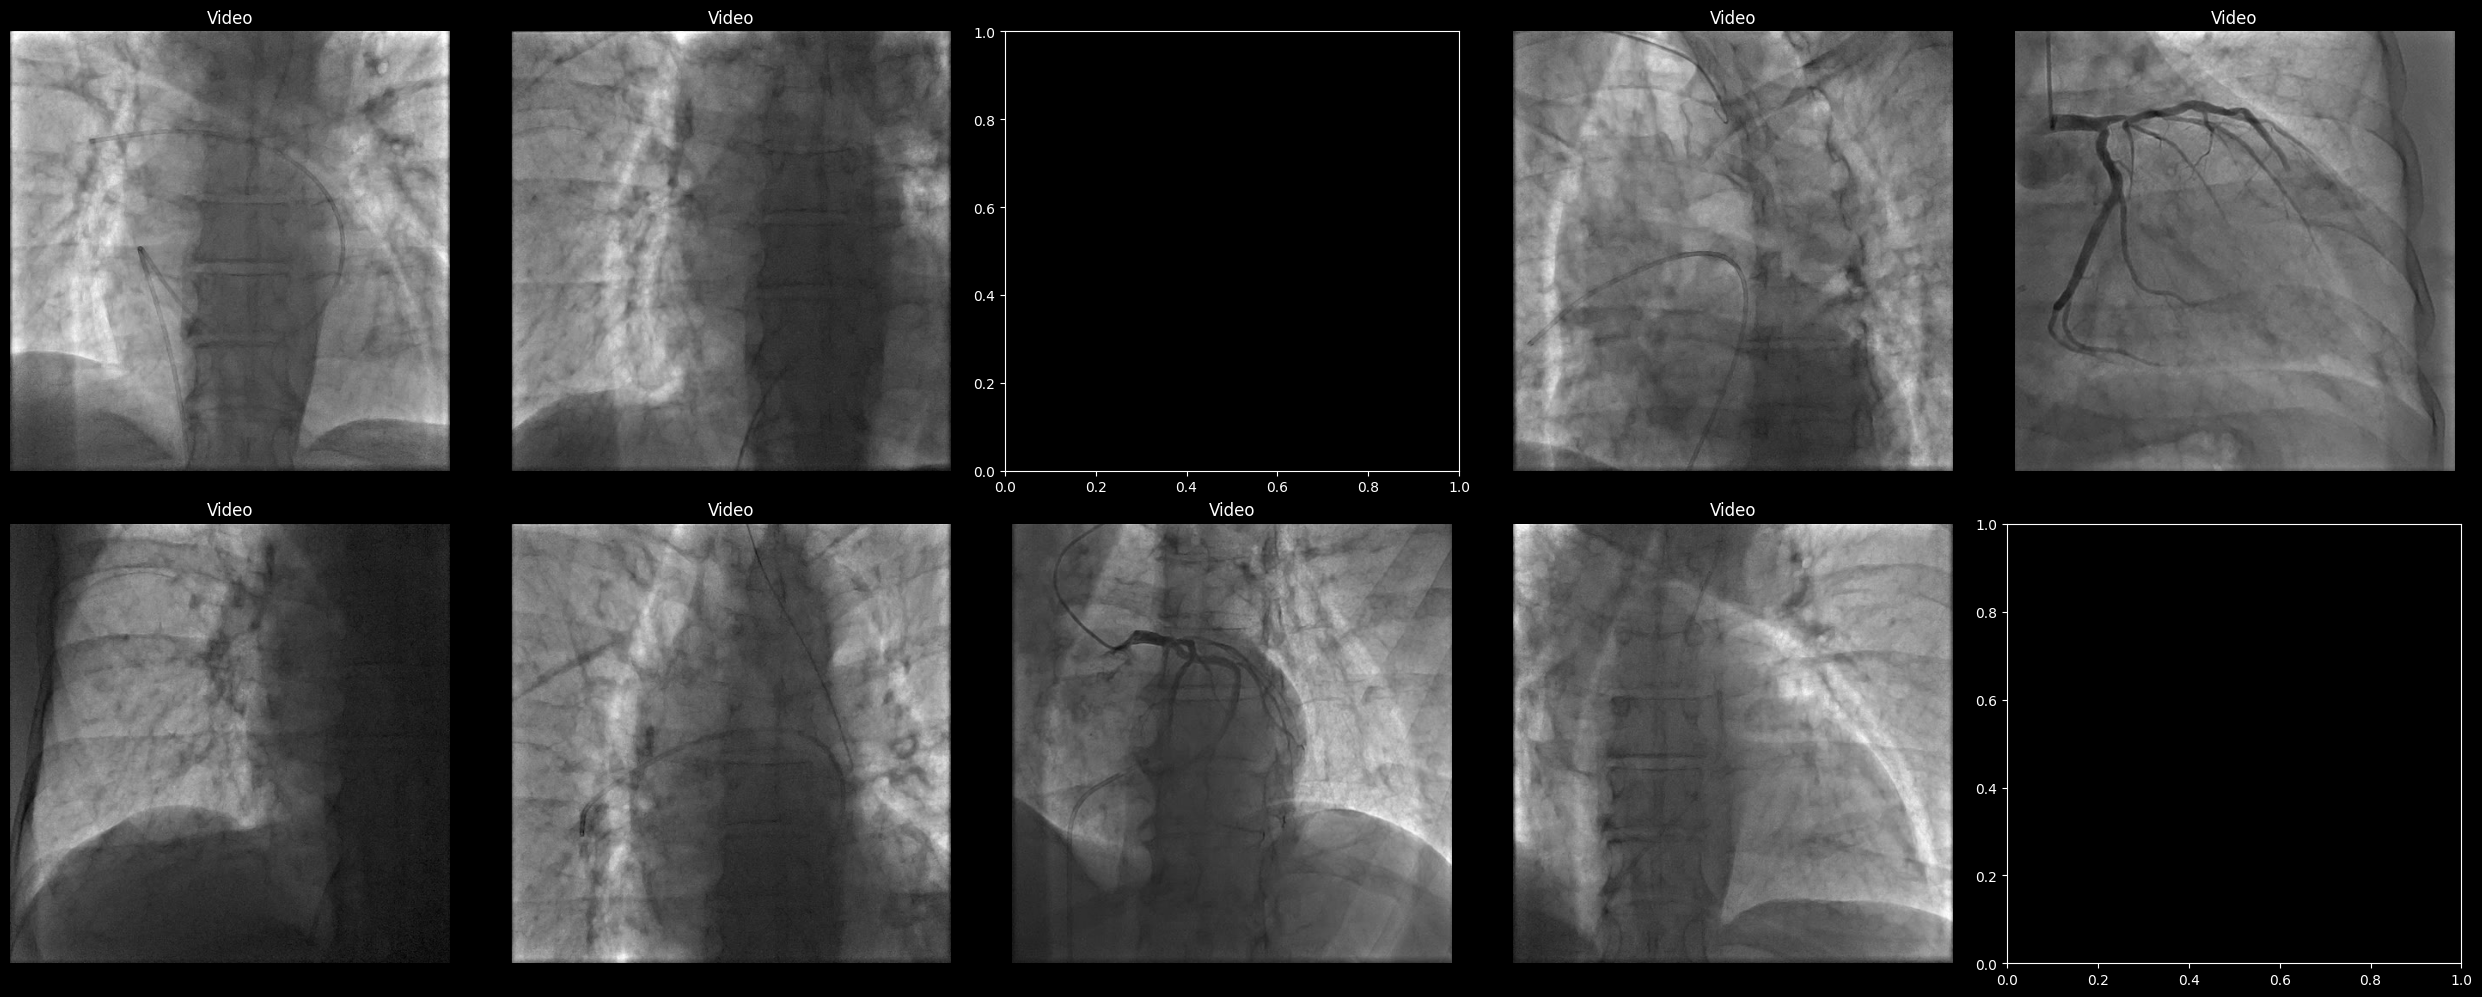

5


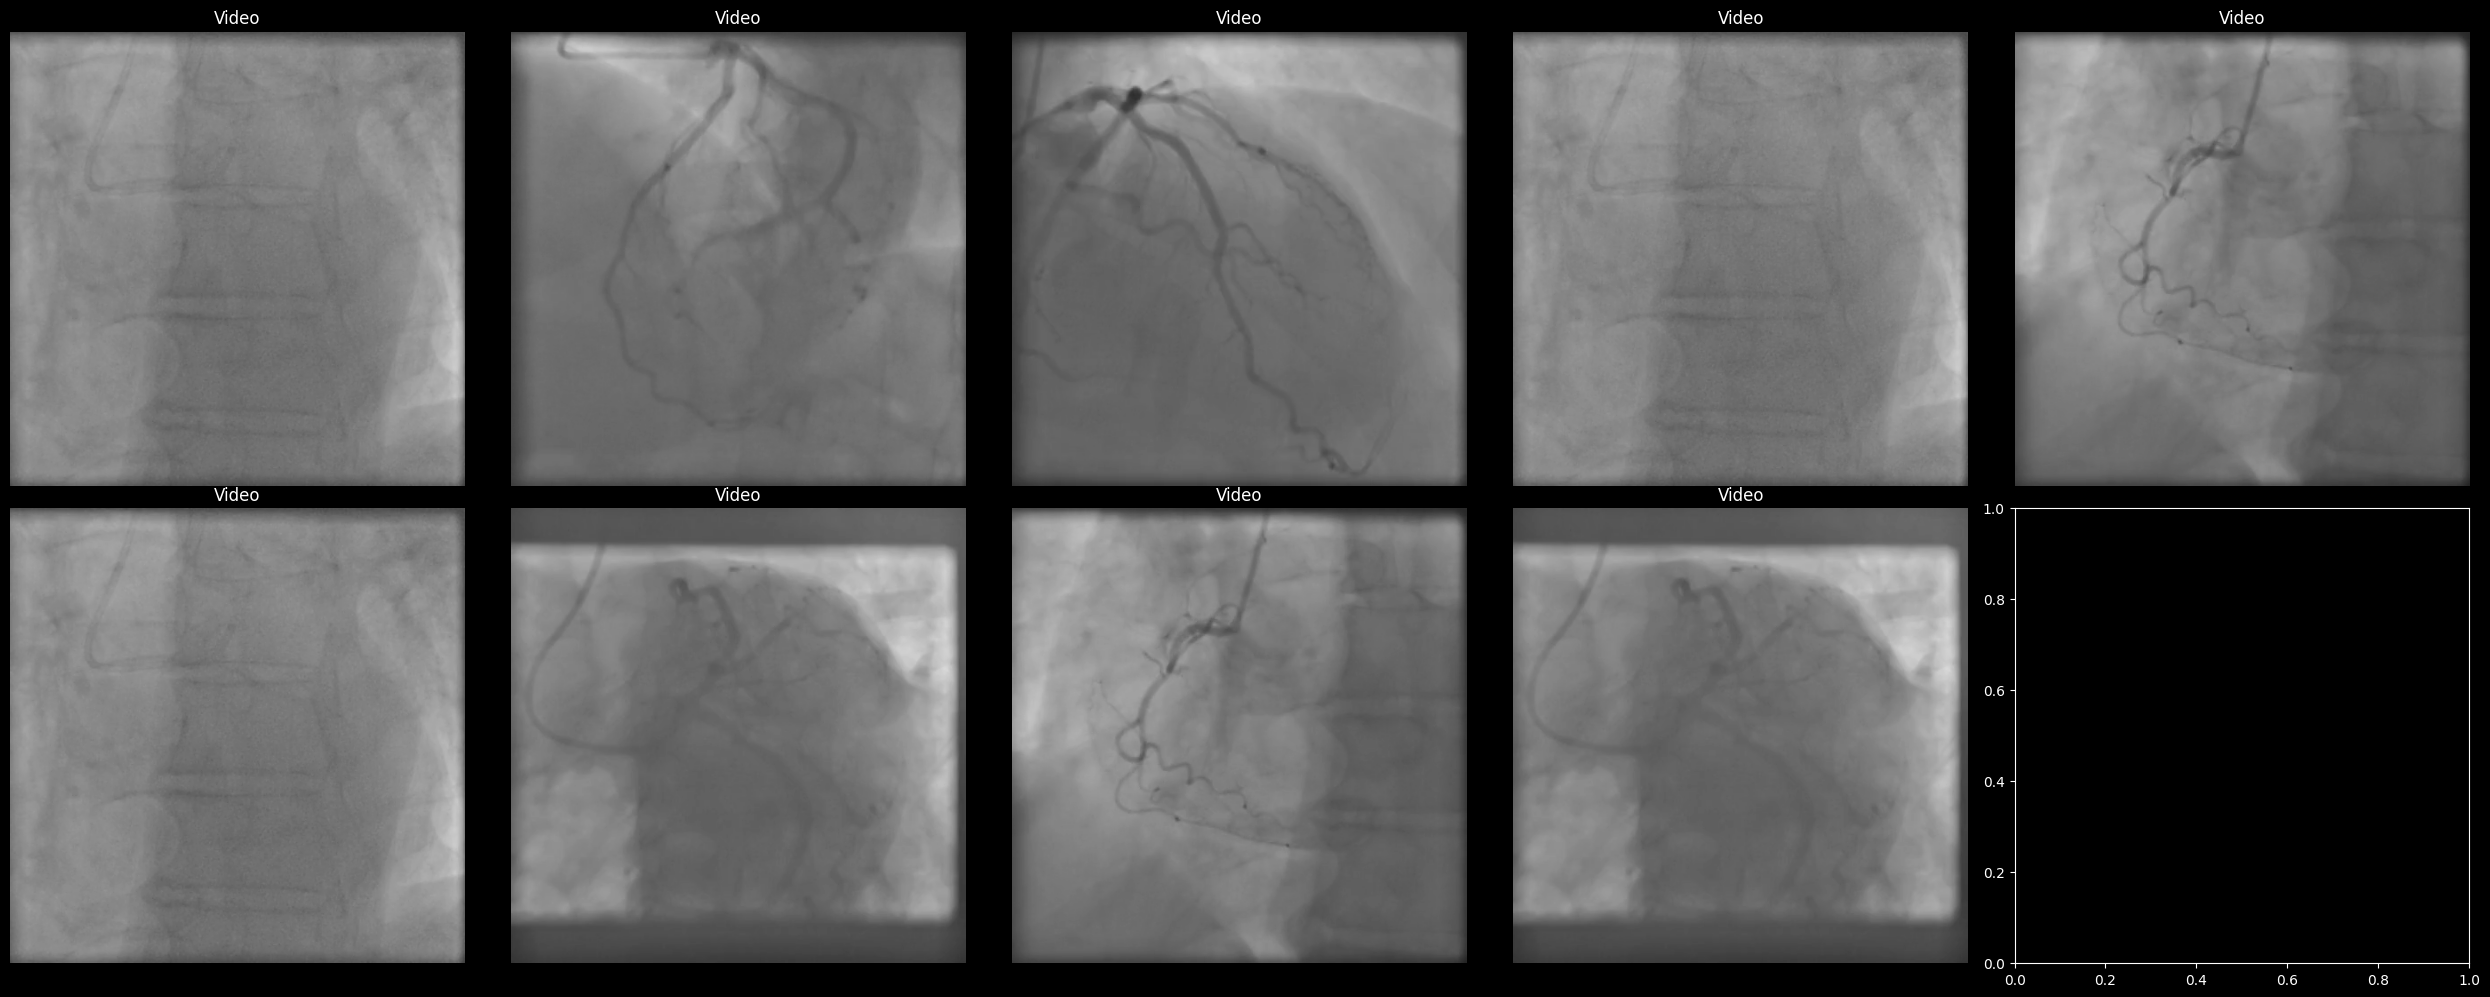

4


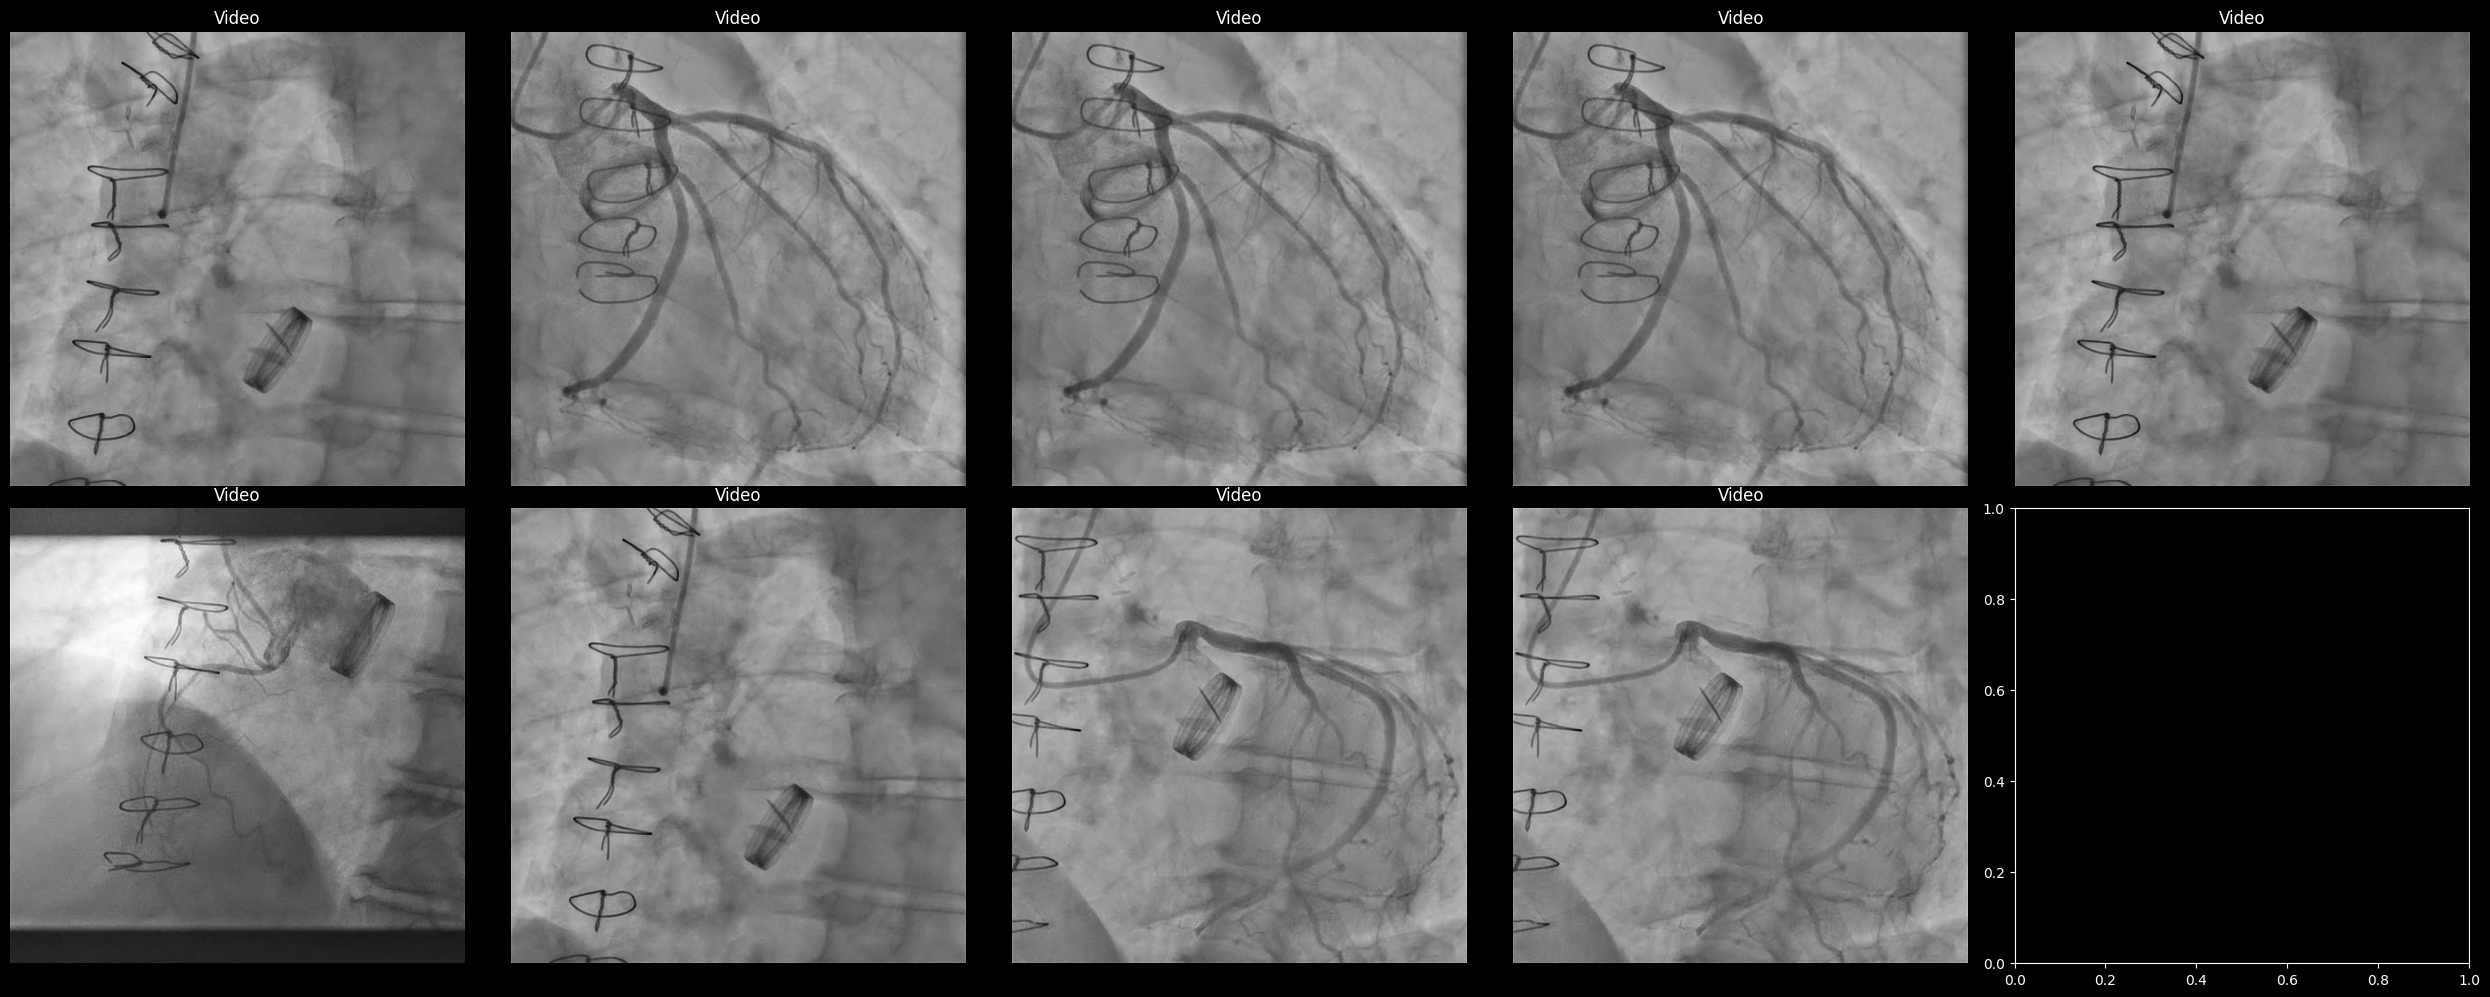

In [15]:
import sys
import os
import numpy as np
## CHANGE THIS
dir2 = os.path.abspath("/volume/DicomVideoProcessing/downloadAvi")
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

from downloadAvi import plot_avi

# Sample 2-3 random StudyInstanceUIDs
study_ids = df_predictions.loc[df_predictions['coronary_dominance_consensus']=='co_dominant']['StudyInstanceUID'].unique()

sampled_studies = np.random.choice(study_ids, size=3, replace=False)

# For each sampled study, plot 8 videos
for study_id in sampled_studies:
    study_videos = df_predictions[df_predictions['StudyInstanceUID'] == study_id]
    if len(study_videos) >= 3:
        study_sample = study_videos.sample(n=9, replace=len(study_videos) < 9)
        print(study_sample.FileName.nunique())
        plot_avi.sample_and_plot_middle_frames(study_sample, 9, 
                                             label_column='Report', 
                                             path_column='FileName')
        
        

In [34]:
# Display number of unique StudyInstanceUID by split and year
print("Number of unique StudyInstanceUID by split:")
print(df_sampled.groupby('Split')['StudyInstanceUID'].nunique())

# Extract year from date column and show breakdown
df_sampled['Year'] = pd.to_datetime(df_sampled['date'], format='%Y%m%d').dt.year
print("\nBreakdown by year:")
print(df_sampled.groupby('Year')['StudyInstanceUID'].nunique())

Number of unique StudyInstanceUID by split:


NameError: name 'df_sampled' is not defined

In [3]:
output_sampled_file_path = pd.read_csv(
    "data/reports/reports_with_alpha_separator_with_Calcifc_Stenosis_IFR_20250108.csv", sep="α"
)
#df_sampled = output_sampled_file_path.sample(96).reset_index()
# Save the dataframe with split information to a new CSV file
#output_sampled_file_path = "data/reports/reports_sampled_no_conclusion_96.csv"
#df_sampled.to_csv(output_sampled_file_path, sep="α", index=False)

/tmp/ipykernel_916145/2549673920.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  output_sampled_file_path = pd.read_csv(


In [ ]:

# For example, view rows with a specific Report value:
output_sampled_file_path[output_sampled_file_path.Report == 'The coronary circulation is right_dominant.'].head(5)

,y_hat,object_value,ManufacturerModelName,sex,FPS,NumberOfFrames,date,StudyTime,SeriesTime,PatientBirthDate,PhotometricInterpretation,StudyInstanceUID,SeriesInstanceUID,DICOMPath,FileName,uint16_video,primary_angle,secondary_angle,Columns,Rows,pixel_spacing,DistanceSourceToDetector,DistanceSourceToPatient,EstimatedRadiographicMagnificationFactor,TableMotion,RadiationSetting,ImagerPixelSpacing,Split,CathReport_MRN,EXAMEN_ID,Num Accession,date/heure,Modality,Patient_ID,QueryRetrieveLevel,DATEEXAMEN,year,SOPInstanceUID,Recommendation,Conclusion,FrameTime,SeriesDescription,External_Exam,angle_value,coronary_dominance_logit,coronary_dominance,D2_stenosis,D3_stenosis,RVG1_stenosis,RVG2_stenosis,S1_stenosis,bx_stenosis,diagonal_stenosis,dist_lad_stenosis,dist_lcx_stenosis,dist_rca_stenosis,lad_stenosis,lcx_stenosis,leftmain_stenosis,lima_or_svg_stenosis,lvp_stenosis,marg_d_stenosis,mid_lad_stenosis,mid_rca_stenosis,om1_stenosis,om2_stenosis,om3_stenosis,pda_stenosis,posterolateral_stenosis,prox_rca_stenosis,D2_IFRHYPEREMIE,D3_IFRHYPEREMIE,RVG1_IFRHYPEREMIE,RVG2_IFRHYPEREMIE,S1_IFRHYPEREMIE,bx_IFRHYPEREMIE,diagonal_IFRHYPEREMIE,dist_lad_IFRHYPEREMIE,dist_lcx_IFRHYPEREMIE,dist_rca_IFRHYPEREMIE,lad_IFRHYPEREMIE,lcx_IFRHYPEREMIE,leftmain_IFRHYPEREMIE,lima_or_svg_IFRHYPEREMIE,lvp_IFRHYPEREMIE,marg_d_IFRHYPEREMIE,mid_lad_IFRHYPEREMIE,mid_rca_IFRHYPEREMIE,om1_IFRHYPEREMIE,om2_IFRHYPEREMIE,om3_IFRHYPEREMIE,pda_IFRHYPEREMIE,posterolateral_IFRHYPEREMIE,prox_rca_IFRHYPEREMIE,D2_calcif,D3_calcif,RVG1_calcif,RVG2_calcif,S1_calcif,bx_calcif,diagonal_calcif,dist_lad_calcif,dist_lcx_calcif,dist_rca_calcif,lad_calcif,lcx_calcif,leftmain_calcif,lima_or_svg_calcif,lvp_calcif,marg_d_calcif,mid_lad_calcif,mid_rca_calcif,om1_calcif,om2_calcif,om3_calcif,pda_calcif,posterolateral_calcif,prox_rca_calcif,D2_IFRBASAL,D3_IFRBASAL,RVG1_IFRBASAL,RVG2_IFRBASAL,S1_IFRBASAL,bx_IFRBASAL,diagonal_IFRBASAL,dist_lad_IFRBASAL,dist_lcx_IFRBASAL,dist_rca_IFRBASAL,lad_IFRBASAL,lcx_IFRBASAL,leftmain_IFRBASAL,lima_or_svg_IFRBASAL,lvp_IFRBASAL,marg_d_IFRBASAL,mid_lad_IFRBASAL,mid_rca_IFRBASAL,om1_IFRBASAL,om2_IFRBASAL,om3_IFRBASAL,pda_IFRBASAL,posterolateral_IFRBASAL,prox_rca_IFRBASAL,D2_CFRBASAL,D3_CFRBASAL,RVG1_CFRBASAL,RVG2_CFRBASAL,S1_CFRBASAL,bx_CFRBASAL,diagonal_CFRBASAL,dist_lad_CFRBASAL,dist_lcx_CFRBASAL,dist_rca_CFRBASAL,lad_CFRBASAL,lcx_CFRBASAL,leftmain_CFRBASAL,lima_or_svg_CFRBASAL,lvp_CFRBASAL,marg_d_CFRBASAL,mid_lad_CFRBASAL,mid_rca_CFRBASAL,om1_CFRBASAL,om2_CFRBASAL,om3_CFRBASAL,pda_CFRBASAL,posterolateral_CFRBASAL,prox_rca_CFRBASAL,D2_CFRHYPEREMIE,D3_CFRHYPEREMIE,RVG1_CFRHYPEREMIE,RVG2_CFRHYPEREMIE,S1_CFRHYPEREMIE,bx_CFRHYPEREMIE,diagonal_CFRHYPEREMIE,dist_lad_CFRHYPEREMIE,dist_lcx_CFRHYPEREMIE,dist_rca_CFRHYPEREMIE,lad_CFRHYPEREMIE,lcx_CFRHYPEREMIE,leftmain_CFRHYPEREMIE,lima_or_svg_CFRHYPEREMIE,lvp_CFRHYPEREMIE,marg_d_CFRHYPEREMIE,mid_lad_CFRHYPEREMIE,mid_rca_CFRHYPEREMIE,om1_CFRHYPEREMIE,om2_CFRHYPEREMIE,om3_CFRHYPEREMIE,pda_CFRHYPEREMIE,posterolateral_CFRHYPEREMIE,prox_rca_CFRHYPEREMIE,D2_FFRHYPEREMIE,D3_FFRHYPEREMIE,RVG1_FFRHYPEREMIE,RVG2_FFRHYPEREMIE,S1_FFRHYPEREMIE,bx_FFRHYPEREMIE,diagonal_FFRHYPEREMIE,dist_lad_FFRHYPEREMIE,dist_lcx_FFRHYPEREMIE,dist_rca_FFRHYPEREMIE,lad_FFRHYPEREMIE,lcx_FFRHYPEREMIE,leftmain_FFRHYPEREMIE,lima_or_svg_FFRHYPEREMIE,lvp_FFRHYPEREMIE,marg_d_FFRHYPEREMIE,mid_lad_FFRHYPEREMIE,mid_rca_FFRHYPEREMIE,om1_FFRHYPEREMIE,om2_FFRHYPEREMIE,om3_FFRHYPEREMIE,pda_FFRHYPEREMIE,posterolateral_FFRHYPEREMIE,prox_rca_FFRHYPEREMIE,D2_FFRBASAL,D3_FFRBASAL,RVG1_FFRBASAL,RVG2_FFRBASAL,S1_FFRBASAL,bx_FFRBASAL,diagonal_FFRBASAL,dist_lad_FFRBASAL,dist_lcx_FFRBASAL,dist_rca_FFRBASAL,lad_FFRBASAL,lcx_FFRBASAL,leftmain_FFRBASAL,lima_or_svg_FFRBASAL,lvp_FFRBASAL,marg_d_FFRBASAL,mid_lad_FFRBASAL,mid_rca_FFRBASAL,om1_FFRBASAL,om2_FFRBASAL,om3_FFRBASAL,pda_FFRBASAL,posterolateral_FFRBASAL,prox_rca_FFRBASAL,acute_coronary_occlusion,pci_regions,PONTAGES,acute_inferior_mi,TITREEXAMEN,Indications,ACS,insuffisance_cardiaque,cardiogenic_shock,CABG,SpecificCharacte

## Example tokenization

In [ ]:
df_sampled = pd.read_csv('data/reports/reports_with_alpha_separator_with_conclusion_and_more_details_20250108.csv', sep='α')

In [3]:
from transformers import AutoTokenizer, AutoModel

# Load PubMedBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

# Get a sample text from the dataframe
sample_text = df_sampled['Report'].iloc[0]

# Encode the text
encoded = tokenizer(
    sample_text,
    padding="max_length",
    max_length=512, 
    truncation=True,
    return_tensors="pt"
)

# Decode back to text to verify
decoded = tokenizer.decode(encoded['input_ids'][0], skip_special_tokens=True)


In [ ]:
# Print full texts without truncation
pd.set_option('display.max_colwidth', None)
print("\nOriginal text (full):")
print(sample_text)
print("\nDecoded text (full):")
print(decoded)
print("\nEncoded tokens:")

NameError: name 'df_sampled' is not defined